# Variance-based sensitivity analysis

S. Eggl

[Variance-based sensitivity analysis](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) decomposes the variance of a model output into fractions that can be attributed to model inputs.
Here we use [SALib](https://salib.readthedocs.io/en/latest/) a sensitivity analysis package to explore which parameters matter most for the impact. Here, we will explore the sensitivity of the momentum enhancehment factor beta to various parameters related to [DART](https://dart.jhuapl.edu/). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

In [4]:
def beta(msc,me,Vinf,Ve,eta,eps):
    """Momentum enhancement factor beta according to DART Beta Memo (2020).
    
    Parameters:
    -----------
    msc    ... [float, kg] mass of DART spacecraft (dry + fuel remnants)
    me     ... [float, kg] total mass of ejecta
    Vinf   ... [float, m/s] incoming relative velocity of DART wrt Dimorphos
    Ve     ... [float, m/s] norm of the sum of all ejecta velocity vectors 
    eta    ... [float, rad] angle between Vinf and surface normal (around 180 deg)
    eps    ... [floa,rad] angle between Ve and surface normal (around 0 deg)
    
    Returns:
    --------
    beta  ... momentum enhancement factor: beta = (msc Vinf.nhat - me Ve.nhat)/(msc Vinf.nhat)
    """
    cos=np.cos
    
    imp = msc*Vinf*cos(eta)
    
    bet = 1 - me*Ve*cos(eps)/imp
    
    return bet
    

In [5]:
beta(600,6000,6000,600,np.pi,0)

2.0

In [10]:
# Define the model inputs and ranges for quasi random sampling
problem = {
    'num_vars': 6,
    'names': ['msc','mejecta','Vinf','Vejecta','eta','eps'],
    'bounds': [[500, 650],
               [0, 6000],
               [5900, 6100],
               [0,600],
               [np.pi/2,3*np.pi/2],
               [-np.pi/4,np.pi/4]]
}
# Number of samples (must be power of 2)
n_samples=2**16
print('Number of samples:',n_samples)

# Generate samples
param_values = saltelli.sample(problem, n_samples)

# Run model (example)
Y = beta(param_values[:,0],param_values[:,1],param_values[:,2],param_values[:,3],param_values[:,4],param_values[:,5])

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)

Number of samples: 65536
Parameter S1 S1_conf ST ST_conf
msc 0.000104 0.000447 0.010483 0.012163
mejecta 0.000176 0.000298 0.189274 0.482265
Vinf 0.000000 0.000010 0.000133 0.000190
Vejecta -0.000542 0.002893 0.268465 0.358728
eta 0.434681 0.357195 0.607377 0.563315
eps -0.000078 0.000348 0.001537 0.003807

Parameter_1 Parameter_2 S2 S2_conf
msc mejecta -0.000195 0.000854
msc Vinf -0.000195 0.000845
msc Vejecta -0.000139 0.000604
msc eta -0.005644 0.051866
msc eps -0.000187 0.000814
mejecta Vinf -0.000053 0.000341
mejecta Vejecta 0.000023 0.000322
mejecta eta 0.059633 0.317820
mejecta eps -0.000049 0.000334
Vinf Vejecta -0.000000 0.000014
Vinf eta -0.001485 0.004488
Vinf eps -0.000002 0.000019
Vejecta eta -0.094340 0.278020
Vejecta eps 0.002385 0.009694
eta eps -0.172222 0.544638


### Print and plot the first-order sensitivity indices

In [11]:
print(Si['S1'])

[ 1.04047330e-04  1.76262111e-04  2.64367027e-07 -5.41984849e-04
  4.34681323e-01 -7.82852773e-05]


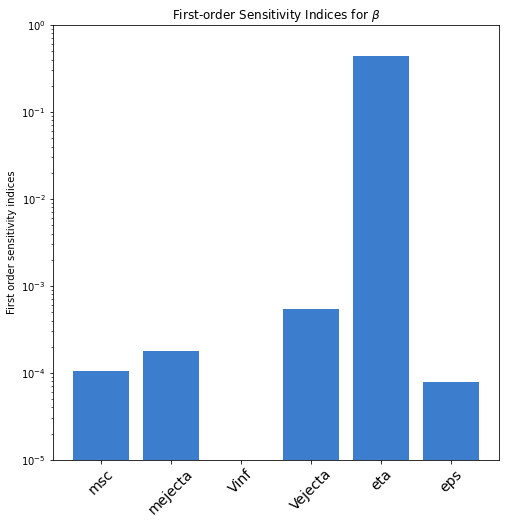

In [12]:
plt.figure(figsize=(8, 8))
dartblue='#3c7dcd'

x = problem['names']
sobol_indices = Si['S1']

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, abs(sobol_indices), color=dartblue)

plt.xticks(range(len(problem['names'])), problem['names'], fontsize=14, rotation=45)
plt.ylabel("First order sensitivity indices")
plt.yscale('log', nonpositive='clip')
plt.ylim(1e-5,1)

plt.title(r'First-order Sensitivity Indices for $\beta$')
plt.show()

We see that the angle between surface normal and DART impact vector (eta) has the largest influence on beta, followed by the net ejecta momentum (mejecta*Vejecta).

### We can look at the second-order indices to see higher-order interactions:

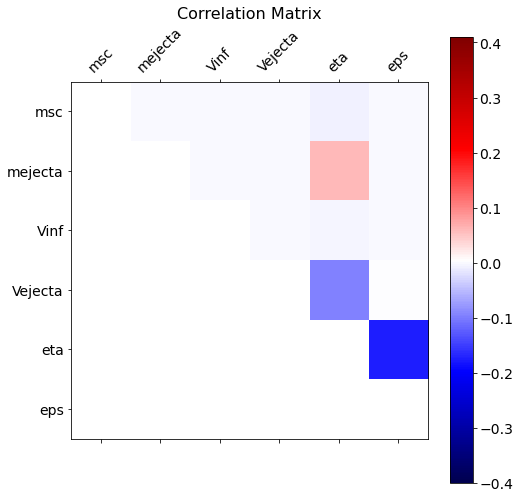

In [13]:
f = plt.figure(figsize=(8, 8))
plt.matshow(Si['S2'], fignum=f.number,cmap=plt.get_cmap('seismic'),vmin=-0.4, vmax=.41)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.xticks(range(len(problem['names'])), problem['names'], fontsize=14, rotation=45)
plt.yticks(range(len(problem['names'])),problem['names'], fontsize=14)
plt.title('Correlation Matrix', fontsize=16);

The correlation between the angles eta and eps wrt beta is clearly visible, although we did not explicitly use the surface normal vector nhat to calculate beta. The dominant quantities are again related to the magnitude of the ejecta momentum, and the angle between the impact vector of DART and the surface normal. 